In [155]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import os

In [53]:
path = os.getcwd() + "/BloodCells/"

In [54]:
def load_image(impath):
    image = cv2.imread(impath)
    return image

In [225]:
# impath1 = path + "/images/TRAIN/NEUTROPHIL/_0_9649.jpeg"
# impath1 = path + "/images/TRAIN/NEUTROPHIL/_0_9649.jpeg"
# impath1 = path + "/images/TRAIN/NEUTROPHIL/_0_1095.jpeg"
impath1 = path + "/images/TRAIN/NEUTROPHIL/_7_5840.jpeg"

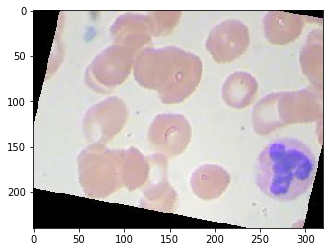

In [226]:
# Load an example image
imtest = load_image(impath1)
plt.imshow(cv2.cvtColor(imtest, cv2.COLOR_BGR2RGB))
plt.show()

In [249]:
# Convert image to grayscale
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

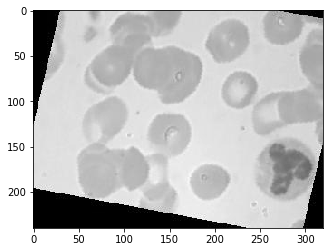

In [250]:
# Plot result of grayscale function
imgray = to_grayscale(imtest)
plt.imshow(imgray, "gray")

In [251]:
# Neutralize black frame by changing its color to average image color
def neutralize_frame(image, thresh=40):
    nonblack_avg = np.mean(imgray[imgray > thresh])
    imgray[imgray < thresh] = nonblack_avg

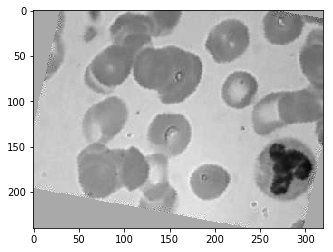

In [252]:
# Test neutralize frame function and plot the result
neutralize_frame(imgray)
plt.imshow(imgray, "gray")

In [266]:
def thresholding(image, thresh=150):
    ret, thresh = cv2.threshold(image, thresh, 255, 0)
    return thresh

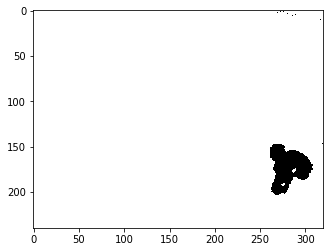

In [267]:
# Threshold the image to locate the darker zones corresponding to the cell we are trying to identify
thresh = thresholding(imgray)
plt.imshow(thresh, "gray")

In [268]:
# We take the average index from the non white-pixels to estimate the center of the cell we are trying to identify
def find_centre(threshim):
    centre = np.mean(np.argwhere(threshim != 255), axis=0).astype(int)
    return centre

In [269]:
# Test find center function
centre = find_centre(thresh)
print(centre)

[171 281]


In [270]:
# Reframe the image with npixs in each dimension around the center
def focus_on_centre(image, npixs=150):
    centre = find_centre(image)
    limx = image.shape[0]
    limy = image.shape[1]
    
    imreduced = imtest[centre[0] - npixs//2 : centre[0] + npixs//2, 
                       centre[1] - npixs//2 : centre[1] + npixs//2, 
                       :]
    return imreduced

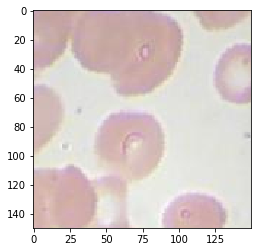

In [271]:
# Test focus on center function
npixs = 150
imreduced = focus_on_centre(imtest, npixs)
plt.imshow(cv2.cvtColor(imreduced, cv2.COLOR_BGR2RGB))

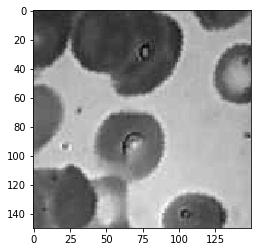

In [272]:
# We use grayscale version to simplify the problem and to be able to vectorize images
reduced_gray = to_grayscale(imreduced)
plt.imshow(reduced_gray, "gray")

In [273]:
# 
def to_normalized_negative(image):
    inverted = (-(reduced_gray - 255)).astype(float)
    normalized = (1.0 / 255.0) * inverted
    return normalized

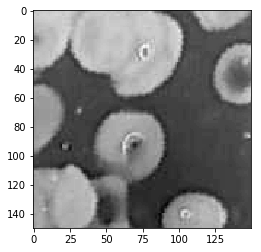

In [274]:
negative = to_normalized_negative(reduced_gray)
plt.imshow(negative, "gray")

In [242]:
def centre_image(image, frame_thresh=40, thresh=150, npixs=150):
    imgray = to_grayscale(image)
    neutralize_frame(imgray, frame_thresh)
    thresholded = thresholding(imgray)
    centre = find_centre(thresholded)
    imreduced = to_grayscale(focus_on_centre(imtest, npixs))
    negative = to_normalized_negative(imreduced)
    return negative

In [243]:
def to_1d(image):
    return image.flatten()

In [244]:
def to_2d(vecimage):
    s = int(np.sqrt(vecimage.shape[0]))
    return vecimage.reshape(s, s)

In [160]:
start = time.clock()
neg = centre_image(imtest)
end = time.clock()
print(end - start)

0.001963


In [245]:
to_2d(to_1d(neg), 150)

TypeError: to_2d() takes exactly 1 argument (2 given)

In [161]:
path_neutrophil = path + "/images/TRAIN/NEUTROPHIL/"
path_lymphocyte = path + "/images/TRAIN/LYMPHOCYTE/"

In [246]:
def process_all_directory(dirpath, frame_thresh=40, thresh=150, npixs=150):
    files = os.listdir(dirpath)
    nfiles = len(files)
    stacked = np.zeros((npixs ** 2, nfiles))
    i = 0
    for f in files : 
        image = load_image(dirpath + f)
        stacked[:, i] = to_1d(centre_image(image, frame_thresh, thresh, npixs))
    return stacked

In [247]:
start = time.clock()
neutrophils = process_all_directory(path_neutrophil)
end = time.clock()
print(end - start)

3.73503


In [171]:
start = time.clock()
lymphocytes = process_all_directory(path_lymphocyte)
end = time.clock()
print(end - start)

3.235927


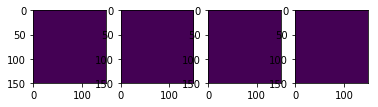

In [248]:
fig, axes = plt.subplots(1, 4)
for i in range(0, 4):
    axes[i].imshow(to_2d(neutrophils[:, 10+i]))